In [13]:
# import the modules
import warnings
warnings.filterwarnings('ignore')

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge,Lasso


### Load the dataset

- Load the train data and using all your knowledge try to explore the different statistical properties of the dataset.

In [14]:
# Code starts here
train = pd.read_csv("train.csv")

# drop serial number
train.drop(columns='Serial Number',inplace=True)
print(train.head())



# Code ends here

     Id  total_net_assets  net_annual_expenses_ratio  morningstar_rating  \
0  3768            211000                       1.90                   3   
1  6244          98930000                       1.57                   2   
2  2230         440000000                       0.53                   4   
3  7518          56050000                       0.93                   3   
4  8037         173040000                       2.26                   2   

   portfolio_cash  portfolio_stocks  portfolio_bonds  portfolio_others  \
0            0.95             99.05             0.00              0.00   
1            0.00              0.00           100.00              0.00   
2            1.71              0.00            98.29              0.00   
3            2.64             31.29            57.06              0.80   
4            5.24             94.75             0.00              0.01   

   portfolio_preferred  portfolio_convertable  ...  category_102  \
0                 0.00        

### Visualize the data

- Check for the categorical & continuous features. 
- Check out the best plots for plotting between categorical target and continuous features and try making some inferences from these plots.
- Check for the correlation between the features and do some Hypothesis Testing to see if there is strong association between features.
- Clean the data, remove correlated features and apply some data preprocessing techniques

In [15]:
# Code starts here




""" Perform Hypothesis Testing
The bank suspects is that there is a strong assosciation between `morningstar return rating`  and `morningstar risk rating`. 
Now let's check it by using null hypothesis. Since both are categorical columns, we will do chi-square test to test the same.

- Null Hypothesis : Both the features are independent from each other.
- Alternative Hypothesis : Both features are dependent on each other.

""" 
# Critical value 
critical_value = stats.chi2.ppf(q = 0.95, # Find the critical value for 95% confidence*
                      df = 11)   # Df = number of variable categories(in purpose) - 1

# Subsetting the dataframe
return_rating = train.morningstar_return_rating.value_counts()
risk_rating = train.morningstar_risk_rating.value_counts()

#Concating yes and no into a single dataframe
observed=pd.concat([return_rating.transpose(),risk_rating.transpose()], axis = 1,keys=['return','risk'])

chi2, p, dof, ex = chi2_contingency(observed)


print("p value")
print(p)


print("Chi Statistic")
print(chi2)


p value
0.00032309085443671745
Chi Statistic
23.099539737235563


In [16]:
# Remove Correlated Feature

# check the correlation
correlation = train.corr().abs()

# unstack and sort the values
us_correlation = correlation.unstack()
us_correlation = us_correlation.sort_values(ascending=False)

# max correlated features between 0.75 to 1
max_correlated = us_correlation[(us_correlation>0.75) & (us_correlation<1)]


print(max_correlated)

morningstar_rating         morningstar_return_rating    0.964080
morningstar_return_rating  morningstar_rating           0.964080
portfolio_bonds            portfolio_stocks             0.917010
portfolio_stocks           portfolio_bonds              0.917010
category_12                portfolio_convertable        0.899705
portfolio_convertable      category_12                  0.899705
mean_annual_return_3y      sharpe_ratio_3y              0.766910
sharpe_ratio_3y            mean_annual_return_3y        0.766910
dtype: float64


In [17]:
# drop highly correlated features
train.drop(columns=['morningstar_rating','portfolio_stocks','category_12','sharpe_ratio_3y'],inplace=True)


[Text(0.5, 1.0, 'net_annual_expenses_ratio')]

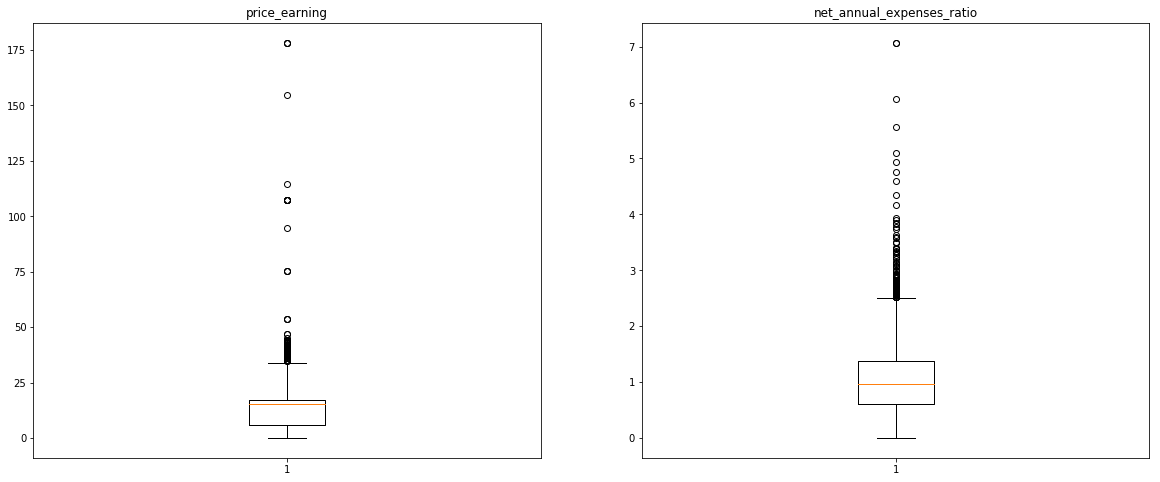

In [18]:
# Plot the box plot for price_earning and net_annual_expenses. So that we can check the outlier.

#Setting up the subplots
fig, (ax_1, ax_2) = plt.subplots(1,2, figsize=(20,8))

#Plotting box plot
ax_1.boxplot(train['price_earning'])

#Setting the subplot axis title
ax_1.set(title='price_earning')

#Plotting box plot
ax_2.boxplot(train['net_annual_expenses_ratio'])

#Setting the subplot axis title
ax_2.set(title='net_annual_expenses_ratio')


### Model building

- Separate the features and target.
- Now let's come to the actual task, using linear regression, predict the `bonds_aaa`. Use different techniques you have learned to imporove the performance of the model.
- Try improving upon the square root of `mean_squared_error` ([Root Mean Squared Error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)) using different parameters that give the best score.


In [19]:
# Code Starts here

# Split the data into train and test
X = train.drop(columns = ['bonds_aaa'])
y = train[['bonds_aaa']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

# Instantiate linear model
lr = LinearRegression()

# fit the model on training data
lr.fit(X_train,y_train)

# predict on test
y_pred = lr.predict(X_test)

#Calculate rmse
rmse = np.sqrt(mean_squared_error(y_pred,y_test))
print("RMSE: ", rmse)


# Code ends here

RMSE:  16.063572903455963


In [20]:
# predict the `bonds_aaa` using lasso regressor and ridge regressor with the help of gridsearch cv to improve the prediction.

# regularization parameters for grid search
ridge_lambdas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60]
lasso_lambdas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1]

# Code starts here

# Instantiate ridge models
ridge_model = Ridge()

# apply ridge model
ridge_grid = GridSearchCV(estimator=ridge_model, param_grid=dict(alpha=ridge_lambdas))
ridge_grid.fit(X_train, y_train)

# make predictions 
ridge_pred = ridge_grid.predict(X_test)
ridge_rmse = np.sqrt(mean_squared_error(ridge_pred, y_test))
print("Ridge RMSE:", ridge_rmse)

# Instantiate lasso models
lasso_model = Lasso()

# apply lasso model
lasso_grid = GridSearchCV(estimator=lasso_model, param_grid=dict(alpha=lasso_lambdas))
lasso_grid.fit(X_train, y_train)

# make predictions
lasso_pred = lasso_grid.predict(X_test)
lasso_rmse = np.sqrt(mean_squared_error(lasso_pred, y_test))
print("Lasso RMSE:", lasso_rmse)

Ridge RMSE: 16.065306137431957
Lasso RMSE: 16.08126906729195


### Prediction on the test data and creating the sample submission file.

- Load the test data and store the `Id` column in a separate variable.
- Perform the same operations on the test data that you have performed on the train data.
- Create the submission file as a `csv` file consisting of the `Id` column from the test data and your prediction as the second column.

In [22]:
# Code Starts here
# Prediction on test data

# Read the test data
test = pd.read_csv('test.csv')

# Storing the id from the test file
id_ = test['Id']

# Dropping the same columns from the test data and applying same transformation
# Apply the transformations on X_test(remove correlated features)
test.drop(columns=['Serial Number','morningstar_rating','portfolio_stocks','category_12','sharpe_ratio_3y'],inplace=True)


# Predict on the test data
y_pred_test = lr.predict(test)
y_pred_test = y_pred_test.flatten()

# Create a sample submission file
sample_submission = pd.DataFrame({'Id':id_,'bonds_aaa':y_pred_test})

# Convert the sample submission file into a csv file
sample_submission.to_csv('sample_submission.csv',index=False)

# Code ends here